### Agenda:
1. Data Loading & Preprocessing
   - Pivoting
   - Missing values handling
   - Date features creation
   - Train/Test split
   - Scaling
   - Sequences
   - Data Loader (incl. indexing for Basisformer)
2. Chronos Model
3. BasisFormer
4. Non-Stationary Transformer
5. iTransformer
6. Synthtic Data Generation
   - Chronos Simulation Framework
   - DYNOTEARS Causal Structure
   - Non linear causal structure
   - Augmentation


In [15]:
#!pip install torch==2.0.1

# Preprocessing

In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.utils.weight_norm as wn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import argparse
import os
import logging
import time

In [17]:
#from torch.utils.tensorboard import SummaryWriter

In [18]:
##file_path = '/content/all_countries.csv' ## colab path
file_path = 'data/all_countries.csv' ## jupyter path
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
df.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Austria,AUT,2015-01-01 00:00:00,2015-01-01 01:00:00,17.93
1,Austria,AUT,2015-01-01 01:00:00,2015-01-01 02:00:00,15.17
2,Austria,AUT,2015-01-01 02:00:00,2015-01-01 03:00:00,16.38
3,Austria,AUT,2015-01-01 03:00:00,2015-01-01 04:00:00,17.38
4,Austria,AUT,2015-01-01 04:00:00,2015-01-01 05:00:00,16.38


In [19]:
df = df [['Country','Datetime (UTC)',  'Price (EUR/MWhe)']]
df = df.pivot(index='Datetime (UTC)', columns='Country', values='Price (EUR/MWhe)')
df.head()

Country,Austria,Belgium,Bulgaria,Croatia,Czechia,Denmark,Estonia,Finland,France,Germany,...,Norway,Poland,Portugal,Romania,Serbia,Slovakia,Slovenia,Spain,Sweden,Switzerland
Datetime (UTC),,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,17.93,34.94,NaN,NaN,24.20,18.29,23.37,23.37,34.94,17.93,...,27.36,17.18,48.10,44.17,NaN,24.20,23.25,48.10,23.37,43.43
2015-01-01 01:00:00,15.17,32.19,NaN,NaN,22.06,16.04,19.33,19.33,32.19,15.17,...,27.24,17.38,47.33,39.17,NaN,22.06,22.20,47.33,19.33,38.08
2015-01-01 02:00:00,16.38,28.05,NaN,NaN,20.27,14.60,17.66,17.66,23.53,16.38,...,27.16,17.40,42.27,26.93,NaN,20.27,19.56,42.27,17.66,35.47
2015-01-01 03:00:00,17.38,28.04,NaN,NaN,19.17,14.95,17.53,17.53,22.92,17.38,...,27.15,18.60,38.41,20.94,NaN,19.17,18.88,38.41,17.53,30.83
2015-01-01 04:00:00,16.38,34.26,NaN,NaN,17.90,14.50,18.07,18.07,34.26,16.38,...,27.30,19.30,35.72,18.52,NaN,17.90,18.39,35.72,18.07,28.26


In [20]:
print(df.isnull().sum())

Country
Austria                0
Belgium                0
Bulgaria           15336
Croatia            24096
Czechia                0
Denmark                0
Estonia                0
Finland                0
France                 0
Germany                0
Greece                 0
Hungary                0
Ireland            12480
Italy                  0
Latvia                 0
Lithuania              0
Luxembourg             0
Netherlands            0
North Macedonia    73008
Norway                 0
Poland                 0
Portugal               0
Romania                0
Serbia             16800
Slovakia               0
Slovenia               0
Spain                  0
Sweden                 0
Switzerland            0
dtype: int64


In [21]:
df = df.dropna(axis=1)
print(df.isnull().sum())

Country
Austria        0
Belgium        0
Czechia        0
Denmark        0
Estonia        0
Finland        0
France         0
Germany        0
Greece         0
Hungary        0
Italy          0
Latvia         0
Lithuania      0
Luxembourg     0
Netherlands    0
Norway         0
Poland         0
Portugal       0
Romania        0
Slovakia       0
Slovenia       0
Spain          0
Sweden         0
Switzerland    0
dtype: int64


In [22]:
df.reset_index(inplace=True)
df.columns.name = None
print(df.head())

        Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  Finland  \
0  2015-01-01 00:00:00    17.93    34.94    24.20    18.29    23.37    23.37   
1  2015-01-01 01:00:00    15.17    32.19    22.06    16.04    19.33    19.33   
2  2015-01-01 02:00:00    16.38    28.05    20.27    14.60    17.66    17.66   
3  2015-01-01 03:00:00    17.38    28.04    19.17    14.95    17.53    17.53   
4  2015-01-01 04:00:00    16.38    34.26    17.90    14.50    18.07    18.07   

   France  Germany  Greece  ...  Netherlands  Norway  Poland  Portugal  \
0   34.94    17.93   48.78  ...        34.94   27.36   17.18     48.10   
1   32.19    15.17   31.10  ...        32.19   27.24   17.38     47.33   
2   23.53    16.38   20.78  ...        28.05   27.16   17.40     42.27   
3   22.92    17.38   25.40  ...        28.04   27.15   18.60     38.41   
4   34.26    16.38   26.00  ...        34.26   27.30   19.30     35.72   

   Romania  Slovakia  Slovenia  Spain  Sweden  Switzerland  
0    44.17   

In [23]:
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])
last_time_point = df['Datetime (UTC)'].max()
print("Last time point available:", last_time_point)

Last time point available: 2024-04-30 23:00:00


In [24]:
start_date = '2023-05-01 01:00:00' ## FILTERING ONLY FOR ONE YEAR
df = df[df['Datetime (UTC)'] >= pd.to_datetime(start_date)]
print(df)

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
73009 2023-05-01 01:00:00    89.98    90.88    90.03    84.03    39.89   
73010 2023-05-01 02:00:00    87.38    87.61    87.34    82.38    42.55   
73011 2023-05-01 03:00:00    88.00    88.00    88.00    84.50    44.83   
73012 2023-05-01 04:00:00    87.25    87.44    87.14    80.62    47.89   
73013 2023-05-01 05:00:00    86.46    91.89    85.53    78.68    56.11   
...                   ...      ...      ...      ...      ...      ...   
81787 2024-04-30 19:00:00    87.82    87.02    88.29    66.05    88.36   
81788 2024-04-30 20:00:00    77.50    75.39    77.99    54.09    78.02   
81789 2024-04-30 21:00:00    76.10    77.51    75.93    50.98    54.93   
81790 2024-04-30 22:00:00    64.22    58.00    67.16    44.71    38.00   
81791 2024-04-30 23:00:00    54.89    54.28    56.35    44.18    36.61   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
73009    39.89   90.59    89.98  1

In [25]:
df['month'] = df['Datetime (UTC)'].apply(lambda row: row.month)
df['day'] = df['Datetime (UTC)'].apply(lambda row: row.day)
df['weekday'] = df['Datetime (UTC)'].apply(lambda row: row.weekday())
df['hour'] = df['Datetime (UTC)'].apply(lambda row: row.hour)

print(df.head())

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
73009 2023-05-01 01:00:00    89.98    90.88    90.03    84.03    39.89   
73010 2023-05-01 02:00:00    87.38    87.61    87.34    82.38    42.55   
73011 2023-05-01 03:00:00    88.00    88.00    88.00    84.50    44.83   
73012 2023-05-01 04:00:00    87.25    87.44    87.14    80.62    47.89   
73013 2023-05-01 05:00:00    86.46    91.89    85.53    78.68    56.11   

       Finland  France  Germany  Greece  ...  Romania  Slovakia  Slovenia  \
73009    39.89   90.59    89.98  129.80  ...    90.05     90.02     90.10   
73010    42.55   87.40    87.29  129.89  ...    87.34     87.33     87.36   
73011    44.83   88.00    88.00  129.19  ...    88.00     88.00     88.00   
73012    47.89   87.38    87.16  110.06  ...    74.59     87.06     87.38   
73013    56.11   89.56    84.20  110.06  ...    41.34     85.10     86.83   

       Spain  Sweden  Switzerland  month  day  weekday  hour  
73009  90.59   39.89        9

In [26]:
# separating the electricity prices and timestamp features
electricity_prices_df = df[['Datetime (UTC)', 'Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
              'Germany', 'Greece', 'Hungary', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
             'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia',
             'Slovenia', 'Spain', 'Sweden', 'Switzerland']]
timestamp_features_df = df[['Datetime (UTC)', 'month', 'day', 'weekday', 'hour']]

# defining the split ratio
train_size = 0.8
train_size_electricity = int(len(electricity_prices_df) * train_size)
train_size_timestamp = int(len(timestamp_features_df) * train_size)

# spliting the data into train and test sets
electricity_prices_train = electricity_prices_df[:train_size_electricity]
electricity_prices_test = electricity_prices_df[train_size_electricity:]
timestamp_features_train = timestamp_features_df[:train_size_timestamp]
timestamp_features_test = timestamp_features_df[train_size_timestamp:]

In [27]:
print(electricity_prices_train.head())

           Datetime (UTC)  Austria  Belgium  Czechia  Denmark  Estonia  \
73009 2023-05-01 01:00:00    89.98    90.88    90.03    84.03    39.89   
73010 2023-05-01 02:00:00    87.38    87.61    87.34    82.38    42.55   
73011 2023-05-01 03:00:00    88.00    88.00    88.00    84.50    44.83   
73012 2023-05-01 04:00:00    87.25    87.44    87.14    80.62    47.89   
73013 2023-05-01 05:00:00    86.46    91.89    85.53    78.68    56.11   

       Finland  France  Germany  Greece  ...  Netherlands  Norway  Poland  \
73009    39.89   90.59    89.98  129.80  ...         92.5   71.30   89.97   
73010    42.55   87.40    87.29  129.89  ...         88.5   69.86   87.30   
73011    44.83   88.00    88.00  129.19  ...         88.0   70.36   88.00   
73012    47.89   87.38    87.16  110.06  ...         87.7   70.96   87.08   
73013    56.11   89.56    84.20  110.06  ...         98.0   74.68   84.46   

       Portugal  Romania  Slovakia  Slovenia  Spain  Sweden  Switzerland  
73009     90.59  

In [28]:
#country_names = electricity_prices_train.drop(columns=['Datetime (UTC)']).columns.tolist()

In [29]:
# rescaling the electricity prices
scaler = StandardScaler()

electricity_prices_train_scaled = scaler.fit_transform(electricity_prices_train.drop(columns=['Datetime (UTC)']))
electricity_prices_test_scaled = scaler.fit_transform(electricity_prices_test.drop(columns=['Datetime (UTC)']))

In [30]:
electricity_prices_train_scaled

array([[ 5.09594693e-02,  1.95064551e-01,  3.98979687e-02, ...,
         2.32680537e-01, -1.37077531e-01,  1.32546620e-01],
       [-1.47782936e-02,  1.11942343e-01, -2.81065887e-02, ...,
         1.42841572e-01, -7.07292965e-02,  9.76612154e-02],
       [ 8.97634477e-04,  1.21856001e-01, -1.14214557e-02, ...,
         1.59739183e-01, -1.38593811e-02,  1.51961106e-01],
       ...,
       [-7.72291683e-02, -2.04023724e-01, -4.27692814e-02, ...,
        -1.04365235e+00, -2.37098742e-01, -3.25210560e-01],
       [ 4.40582133e-01,  2.60239758e-02,  4.70424963e-01, ...,
        -4.68851948e-01, -1.48800716e-01, -2.32688400e-01],
       [ 3.17438155e-02,  6.61869997e-02,  3.71171132e-02, ...,
         1.69543693e-02, -2.37597601e-01, -1.35312618e-01]])

In [31]:
def create_sequences(data, seq_length, pred_length, label_length, curr_model):
    seq_x = [] # storing for input seqiences
    seq_y = [] # storing for output seqiences
    for i in range(len(data) - seq_length - pred_length):
        seq_x.append(data[i:i+seq_length])
        if curr_model in ["basis_former", "itransformer", "nonstat_tran"]:
          seq_y.append(data[i+seq_length-label_length:i+seq_length+pred_length])
        else: ## only chronos
          seq_y.append(data[i+seq_length:i+seq_length+pred_length])
    return np.array(seq_x), np.array(seq_y)

In [32]:
def create_dataloader(seq_x, seq_y, seq_x_mark, seq_y_mark, batch_size, curr_model):
    seq_x = torch.tensor(seq_x, dtype=torch.float32)
    seq_y = torch.tensor(seq_y, dtype=torch.float32)
    seq_x_mark = torch.tensor(seq_x_mark, dtype=torch.float32)
    seq_y_mark = torch.tensor(seq_y_mark, dtype=torch.float32)
    
    # index for each sequence
    if curr_model == "basis_former" :
      indices = []
      for i in range(len(seq_x)):
          index_list = np.arange(i, i + len(seq_x[0]) + len(seq_y[0]), 1)
          norm_index = index_list / len(seq_x) 
          indices.append(norm_index)
      indices = torch.tensor(indices, dtype=torch.float32)
      dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark, indices) #### indices specific to Basisformer
    else :
      dataset = TensorDataset(seq_x, seq_y, seq_x_mark, seq_y_mark)
    if curr_model == "chronos":
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    else :
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, shuffle=True)
    return dataloader


# Chronos

zero shot evaluation with Chronos Pretrained Model

In [5]:
#!pip install git+https://github.com/amazon-science/chronos-forecasting.git
import chronos

In [18]:
batch_size = 8
seq_length = 48 # one week
pred_length = 48 # two days ahead
label_length = 48
curr_model = "chronos"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [19]:
print("Sample testing sequence x:", test_seq_x[0])

Sample testing sequence x: [[ 0.59315114  0.73520287  0.52277371 ...  2.21360706 -0.53971631
   0.40506732]
 [ 0.40055967  0.56420479  0.32383727 ...  2.04845027 -0.56182179
   0.24211759]
 [ 0.33116308  0.4849208   0.25678361 ...  1.95005079 -0.60041271
   0.18324297]
 ...
 [ 0.5310762   0.55647796  0.46525375 ...  0.9861217   0.99043239
   0.21742823]
 [ 1.04613901  1.41314813  1.00581429 ...  1.38357845  1.56554949
   0.5653582 ]
 [ 0.64535775  0.82624507  0.55073922 ...  1.87596176  1.02040592
   0.35986681]]


In [20]:
# Check the dimensions
for batch in test_loader:
    batch_x, batch_y, batch_x_mark, batch_y_mark = batch
    print(f'Input batch shape: {batch_x.shape}')
    print(f'Output batch shape: {batch_y.shape}')
    print(f'Input mark shape: {batch_x_mark.shape}')
    print(f'Output mark shape: {batch_y_mark.shape}')
    break 

Input batch shape: torch.Size([8, 48, 24])
Output batch shape: torch.Size([8, 48, 24])
Input mark shape: torch.Size([8, 48, 4])
Output mark shape: torch.Size([8, 48, 4])


In [22]:
print(ChronosPipeline.predict.__doc__)


        Get forecasts for the given time series.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.
        prediction_length
            Time steps to predict. Defaults to what specified
            in ``self.model.config``.
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            

In [23]:
for batch in test_loader:
    print(batch)
    break  # Print only the first batch and break

[tensor([[[ 0.0757,  0.1666,  0.0494,  ..., -1.3992,  0.4320, -0.0232],
         [-0.1298, -0.0355, -0.1519,  ..., -1.4206,  0.2588, -0.1345],
         [-0.4221, -0.3216, -0.4464,  ..., -1.4740, -0.0386, -0.2476],
         ...,
         [-0.4670, -1.2258, -0.3776,  ..., -1.5061, -0.5688, -0.3962],
         [-0.2850, -1.2147, -0.2181,  ..., -1.5061, -0.5076, -0.2044],
         [-0.0198, -1.0149,  0.0793,  ..., -1.5055, -0.4361,  0.0473]],

        [[-0.9825, -1.2936, -0.6445,  ..., -1.5063, -0.3744, -0.5877],
         [-1.0589, -1.3413, -0.7417,  ..., -1.5069, -0.4522, -1.0247],
         [-1.0525, -1.6215, -0.8558,  ..., -1.5088, -0.4666, -1.0171],
         ...,
         [ 1.5804,  1.6422,  1.5431,  ..., -1.3458,  1.7005,  1.0529],
         [ 0.7101,  0.7888,  0.6785,  ..., -1.4588,  0.9669,  0.3645],
         [ 0.2655,  0.3171,  0.3162,  ..., -1.5061,  0.7007,  0.1207]],

        [[-3.6107, -3.6258, -2.8743,  ..., -1.5063, -0.5771, -4.2673],
         [-3.8564, -3.3772, -3.4957,  ..., -

1. Pad Sequences to the Same Length: Ensure all sequences within a batch have the same length.
2. Flatten the Padded Sequences: Convert the 3D tensor [batch_size, seq_length, num_features] to a 2D tensor [total_sequences, seq_length * num_features].

In [24]:
import torch
from torch.utils.data import DataLoader

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,  # Change to torch.float16 if necessary
)


# padding sequences within a batch
def pad_sequence(sequences, batch_first=True, padding_value=torch.nan):
    return torch.nn.utils.rnn.pad_sequence(sequences, batch_first=batch_first, padding_value=padding_value)

def pad_batch(batch):
    input_ids = batch[0]
    sequences = [input_ids[i] for i in range(input_ids.size(0))]
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences

context = []

# Iterate over the DataLoader to extract and pad input_ids
for batch in test_loader:
    input_ids_padded = pad_batch(batch)
    context.append(input_ids_padded)

# Concatenate the padded tensors to form a 3D tensor
context_tensor_3d = torch.cat(context, dim=0)  # Concatenate along the batch dimension

# Flatten the 3D tensor to 2D
batch_size, seq_length, num_features = context_tensor_3d.shape
context_tensor_2d = context_tensor_3d.view(batch_size, -1)

# Now you can use the context tensor with your pipeline
print(context_tensor_2d.shape)  # To verify the shape


/Users/ekaterinabasova/miniconda3/envs/basisformer_x86_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([776, 1152])


This transformation suggests that each batch of size 24 (sequences) with 96 time steps and 24 features per time step has been flattened into a single 2D tensor.

Original Shape:
Batch size: 24
Sequence length: 96
Number of features: 24

Flattened Shape Calculation:
Flattened feature size: 96×24=2304
Total number of sequences (batches) after concatenation: 16200


The pipeline will process each of these 16,200 sequences, each with 2,304 features.

In [25]:
del context
del context_tensor_3d

# predictions
# 1 hour of running for 2 months
forecast = pipeline.predict(
    context=context_tensor_2d,
    prediction_length=48,
    num_samples=1,
)

In [26]:
forecast

tensor([[[ 0.2803,  0.2950,  0.3049,  ..., -1.2244,  0.5704, -0.0148]],

        [[-2.3152, -0.7957, -1.9084,  ..., -1.3520, -0.1017, -1.2503]],

        [[ 1.7679,  1.2082,  1.9763,  ...,  1.1310,  1.6444,  0.8415]],

        ...,

        [[-0.6537, -0.5191, -0.1538,  ..., -1.3555,  0.1106, -0.0240]],

        [[-0.0354,  0.0071, -0.1132,  ...,  0.4881,  0.1592, -0.2794]],

        [[-2.2143, -0.9113, -2.2383,  ..., -1.4709, -1.4948, -2.4061]]])

In [39]:
# Convert the forecast to a numpy array
forecast_np = forecast[0].numpy()

# Check the shape of forecast_np
print(forecast_np.shape)  # This should print (num_samples, prediction_length)

(1, 48)


In [43]:
forecast_reshaped = forecast_np.flatten()  # Flatten to (48,)
forecast_reshaped = forecast_reshaped.reshape(-1, 1)  # Reshape to (48, 1)
print(forecast_reshaped.shape) 

(48, 1)


In [53]:
rescaled_forecast = (forecast_reshaped * scaler.scale_[0]) + scaler.mean_[0]
rescaled_forecast = rescaled_forecast.reshape(forecast_np.shape)
print(rescaled_forecast.shape)  # Should print (1, 48)

(1, 48)


ValueError: 'y1' is not 1-dimensional

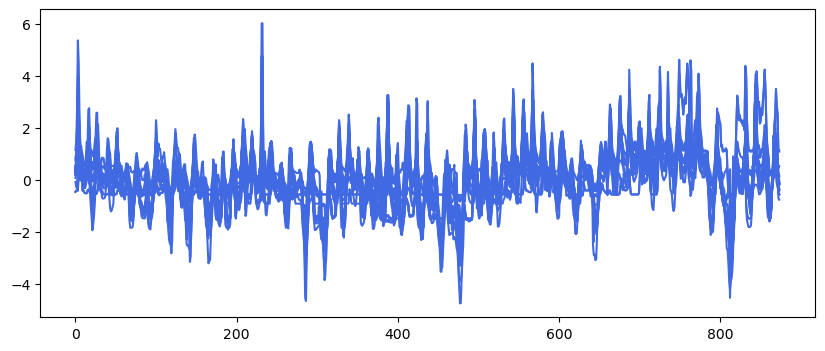

In [59]:
forecast_index = range(len(electricity_prices_test_scaled), len(electricity_prices_test_scaled) + 48)

# Compute quantiles for the forecast
low, median, high = np.quantile(forecast, [0.1, 0.5, 0.9], axis=0)

# Plot the results
plt.figure(figsize=(10, 4))
plt.plot(range(len(electricity_prices_test_scaled)), electricity_prices_test_scaled, color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Electricity Prices')
plt.title('Electricity Prices Forecast')
plt.show()

# Basisformer

In [20]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "basis_former"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


In [21]:
print("Sample training sequence x:", train_seq_x[0])
print("Sample training sequence y:", train_seq_y[0])
print("Sample training sequence x mark:", train_seq_x_mark[0])
print("Sample training sequence y mark:", train_seq_y_mark[0])

Sample training sequence x: [[ 5.09594693e-02  1.95064551e-01  3.98979687e-02 ...  2.32680537e-01
  -1.37077531e-01  1.32546620e-01]
 [-1.47782936e-02  1.11942343e-01 -2.81065887e-02 ...  1.42841572e-01
  -7.07292965e-02  9.76612154e-02]
 [ 8.97634477e-04  1.21856001e-01 -1.14214557e-02 ...  1.59739183e-01
  -1.38593811e-02  1.51961106e-01]
 ...
 [ 8.93907768e-02  2.10824725e-01  7.70603106e-02 ...  7.90301701e-01
   9.10526174e-01 -4.55206197e-02]
 [-1.55861646e-01 -3.57457382e-02 -1.68160584e-01 ...  6.12876785e-01
   7.89802319e-01 -2.01746563e-01]
 [-2.39550875e-01 -1.19884731e-01 -2.51839055e-01 ...  5.36555909e-01
   7.64859373e-01 -2.20857697e-01]]
Sample training sequence y: [[ 0.24867843  0.37096843  0.23632749 ...  0.4357335  -0.69929152
   0.0834037 ]
 [ 0.27623773  0.13507421  0.31343303 ...  0.0907406  -0.38550927
   0.11677235]
 [ 0.5184561   0.42384127  0.55182819 ...  0.25492906  0.27697536
   0.35702662]
 ...
 [ 0.19785809  0.8188624   0.18551368 ...  0.68863441  0.398

In [22]:
batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

/var/folders/y8/hhkwp1r54qg4ztcfjzk9c2800000gn/T/ipykernel_96140/3112801228.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  indices = torch.tensor(indices, dtype=torch.float32)


In [23]:
# Check the dimensions
for batch in test_loader:
    batch_x, batch_y, batch_x_mark, batch_y_mark = batch
    print(f'Input batch shape: {batch_x.shape}')
    print(f'Output batch shape: {batch_y.shape}')
    print(f'Input mark shape: {batch_x_mark.shape}')
    print(f'Output mark shape: {batch_y_mark.shape}')
    break  # Just check the first batch

ValueError: too many values to unpack (expected 4)

In [26]:
pip install adabelief_pytorch==0.2.1

Note: you may need to restart the kernel to use updated packages.


## Train

In [63]:
import importlib
import Basisformer.model
importlib.reload(Basisformer.model)
from Basisformer.model import Basisformer
log_and_print(model)
model.to(device)

Basisformer(
  (coefnet): Coefnet(
    (layers): ModuleList(
      (0-1): 2 x BCAB(
        (cross_attention_basis): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=100, out_features=96, bias=True)
          (key_projection): Linear(in_features=100, out_features=96, bias=True)
          (value_projection): Linear(in_features=100, out_features=96, bias=True)
          (out_projection): Linear(in_features=96, out_features=100, bias=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (conv1_basis): Linear(in_features=100, out_features=400, bias=True)
        (conv2_basis): Linear(in_features=400, out_features=100, bias=True)
        (dropout_basis): Dropout(p=0.1, inplace=False)
        (cross_attention_ts): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=100, out_features=96, bias=True)
          (key_projection): Linear(in_features=100, out_features=96, bias=True)
   

Basisformer(
  (coefnet): Coefnet(
    (layers): ModuleList(
      (0-1): 2 x BCAB(
        (cross_attention_basis): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=100, out_features=96, bias=True)
          (key_projection): Linear(in_features=100, out_features=96, bias=True)
          (value_projection): Linear(in_features=100, out_features=96, bias=True)
          (out_projection): Linear(in_features=96, out_features=100, bias=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (conv1_basis): Linear(in_features=100, out_features=400, bias=True)
        (conv2_basis): Linear(in_features=400, out_features=100, bias=True)
        (dropout_basis): Dropout(p=0.1, inplace=False)
        (cross_attention_ts): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=100, out_features=96, bias=True)
          (key_projection): Linear(in_features=100, out_features=96, bias=True)
   

/Users/ekaterinabasova/miniconda3/envs/basisformer_x86_env/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


[Info] Number of parameters: 612096
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
	iters:

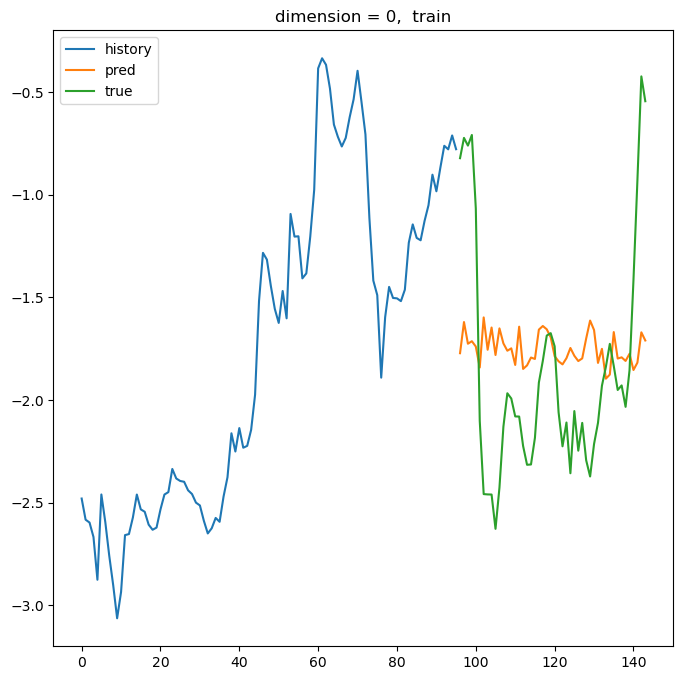

In [36]:
import importlib
import Basisformer.main

# Reload the module to ensure the latest changes are picked up
importlib.reload(Basisformer.main)

# Import the necessary functions and classes
from Basisformer.main import train, create_model, parse_args, get_device

# Parse arguments and get device
args = parse_args()
device = get_device(args)

# Create the model
model = create_model(args, device)

record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                          'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))

# Call the train function
train(model, train_loader, test_loader, args, device, record_dir)



In [ ]:
#!tensorboard --logdir=event

## Test

In [44]:
import importlib
import Basisformer.main
import os

# Reload the module to ensure the latest changes are picked up
importlib.reload(Basisformer.main)

# Import the necessary functions and classes
from Basisformer.main import test, create_model, parse_args, get_device

# Parse arguments and get device
args = parse_args()
device = get_device(args)

# Create the model
model = create_model(args, device)

# Define `record_dir` based on the arguments
record_dir = os.path.join('records', args.data_path.split('.')[0], 'features_' + args.features,
                          'seq_len' + str(args.seq_len) + ',' + 'pred_len' + str(args.pred_len))

# Ensure the directory exists
if not os.path.exists(record_dir):
    os.makedirs(record_dir)

# Example code for creating sequences and dataloaders (replace with actual implementation)
# Assuming `create_sequences` and `create_dataloader` are defined somewhere in your code
seq_length = 96
pred_length = 48
label_length = 48
batch_size = 24
curr_model = "basis_former"


# Call the test function
# Make sure to pass scaler and country_names if needed, or set them to None
test(model, test_loader, record_dir, args, device, scaler=None)


loading model
total_time:5.940980911254883
avg_time:0.0036831871737476023
mse:1.1117128133773804, mae:0.7606538534164429


(0.76065385, 1.1117128, 1.0543779, 466.8383598327637, 957311.03515625)

# iTransformer

In [56]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "itransformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


TypeError: object of type 'ellipsis' has no len()

In [ ]:
print("Sample training sequence x:", train_seq_x[0])
print("Sample training sequence y:", train_seq_y[0])
print("Sample training sequence x mark:", train_seq_x_mark[0])
print("Sample training sequence y mark:", train_seq_y_mark[0])

In [ ]:
batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [55]:
import importlib
import iTransformer.model
importlib.reload(iTransformer.model)
from iTransformer.model import Model, Config

def log_and_print(text):
    logging.info(text)
    print(text)
    return  

configs = Config()
model = Model(configs)
log_and_print(model)

Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (out_projection): Linear(in_features=512, out_features=512, bias=True)
        )
        (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwi

## Train

## Test

# Nonstationary Transformer

In [ ]:
seq_length = 96
pred_length = 48
label_length = 48
curr_model = "itransformer"

train_seq_x, train_seq_y = create_sequences(electricity_prices_train_scaled, seq_length, pred_length, label_length, curr_model)
train_seq_x_mark, train_seq_y_mark = create_sequences(timestamp_features_train.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)


test_seq_x, test_seq_y = create_sequences(electricity_prices_test_scaled, seq_length, pred_length,label_length, curr_model)
test_seq_x_mark, test_seq_y_mark = create_sequences(timestamp_features_test.drop(columns=['Datetime (UTC)']).values, seq_length, pred_length, label_length, curr_model)

batch_size = 24

# converting sequences to PyTorch DataLoader objects
train_loader = create_dataloader(train_seq_x, train_seq_y, train_seq_x_mark, train_seq_y_mark, batch_size, curr_model)
test_loader = create_dataloader(test_seq_x, test_seq_y, test_seq_x_mark, test_seq_y_mark, batch_size, curr_model)

In [ ]:
## but for other model
import importlib
import iTransformer.model
importlib.reload(iTransformer.model)
from iTransformer.model import Model, Config

def log_and_print(text):
    logging.info(text)
    print(text)
    return  

configs = Config()
model = Model(configs)
log_and_print(model)

## Train

## Test

# Sythetic Data Simulation

## Chronos Simulation

In [8]:
!pip install "chronos[training] @ git+https://github.com/amazon-science/chronos-forecasting.git"

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/y8/hhkwp1r54qg4ztcfjzk9c2800000gn/T/pip-install-g4pbpx20/chronos_a9273c93d1c0490cba1cbe7d30f0bc87
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/y8/hhkwp1r54qg4ztcfjzk9c2800000gn/T/pip-install-g4pbpx20/chronos_a9273c93d1c0490cba1cbe7d30f0bc87
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit afd9cfd062b60ca1ba8d7c9daef7dc820489db0a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.1 MB/s eta 0:00:00
  Using cached gluonts-0.15.1-py3-none-any.whl.metadata (9.9 kB)
  Using cached typer-0.12.3-py3-none-any.whl.metadata (15 kB)
  Using cached typer_config-1.4.0-py3-none-any.whl.metadata (4.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [2]:
!python supporting_files_chronos/kernel-synth.py --num-series 500 --max-kernels 2

100%|█████████████████████████████████████████| 500/500 [01:36<00:00,  5.20it/s]


In [3]:
import pyarrow.ipc as ipc

file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch = table.to_pandas()

print(df_ch)

         start                                             target
0   2000-01-01  [0.3690353276138971, 0.44386602613121034, 0.51...
1   2000-01-01  [0.033015551690038884, -0.23397444961837965, -...
2   2000-01-01  [-1.476937197412458, -1.5676278563239772, -1.6...
3   2000-01-01  [-0.16003612245875626, -0.25223661756945526, -...
4   2000-01-01  [-1.3052362051778974, -1.3020472216001648, -1....
..         ...                                                ...
495 2000-01-01  [-1.8427913502113633, -1.8660240145350093, -1....
496 2000-01-01  [-2.2573159760801476, -2.13936135673169, -2.01...
497 2000-01-01  [-1.3484827032112752, -0.9293215555886851, -0....
498 2000-01-01  [0.25171543882670483, 0.21204651463371202, 0.1...
499 2000-01-01  [0.41956252542817685, 0.42232395863695993, 0.4...

[500 rows x 2 columns]


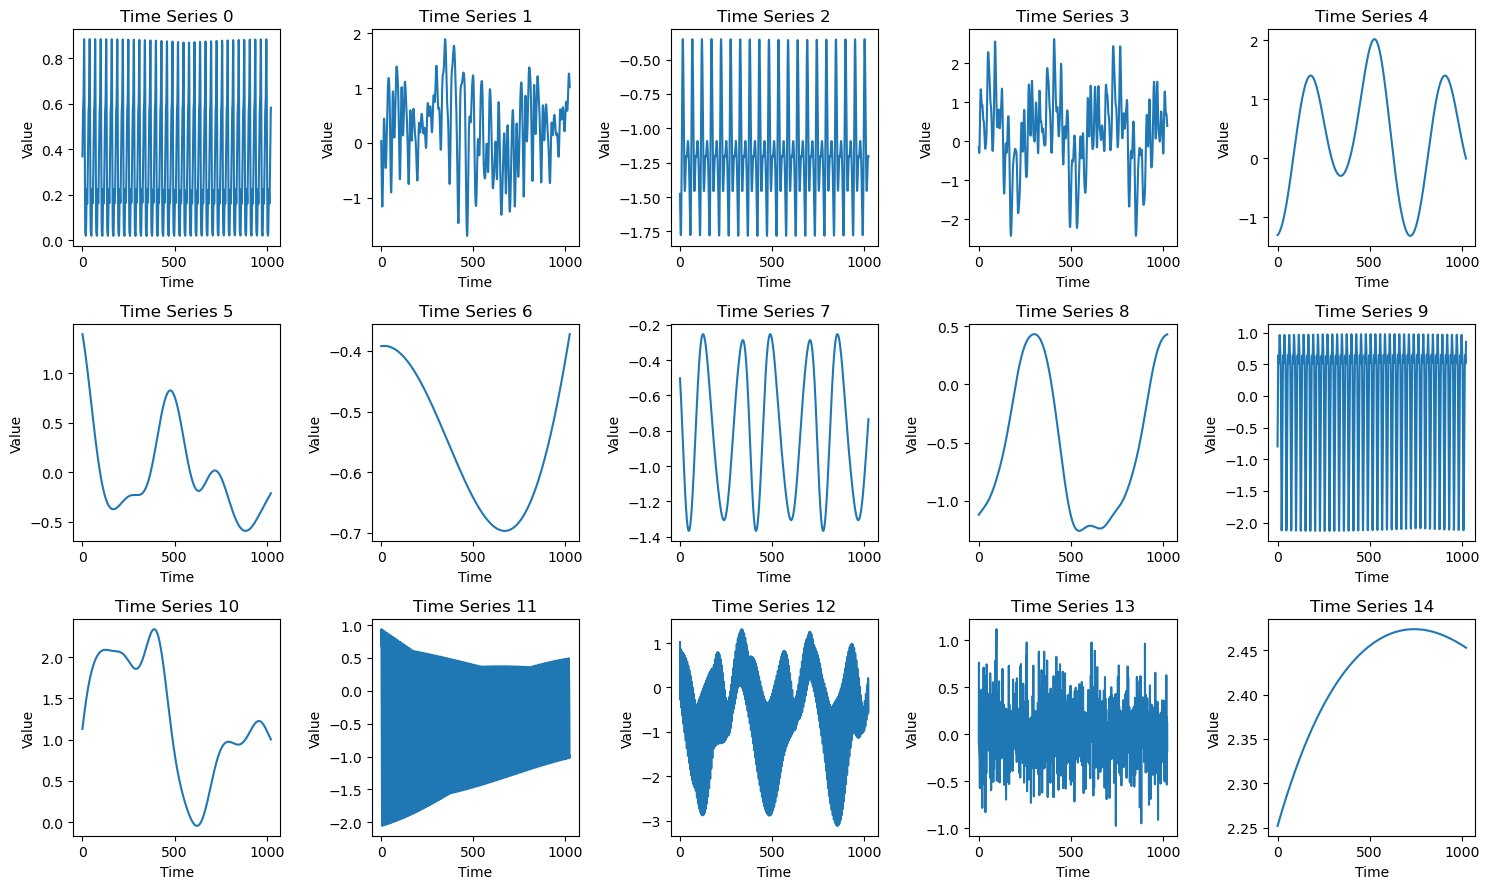

In [6]:
import matplotlib.pyplot as plt 

# Number of time series
num_series = 15
# Number of plots per row
plots_per_row = 5
# Number of rows
num_rows = (num_series + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 3))

for i in range(num_series):
    row = i // plots_per_row
    col = i % plots_per_row
    ax = axes[row, col]
    ax.plot(df_ch['target'].iloc[i])
    ax.set_title(f'Time Series {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

# Remove any empty subplots
for j in range(i + 1, num_rows * plots_per_row):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

In [25]:
!python supporting_files_chronos/kernel-synth-mult.py --num-series 500 --max-kernels 2 --dimensions 3

100%|█████████████████████████████████████████| 500/500 [04:57<00:00,  1.68it/s]


In [26]:
import pyarrow.ipc as ipc

file_path = 'supporting_files_chronos/kernelsynth-data.arrow'

with open(file_path, 'rb') as f:
    reader = ipc.RecordBatchFileReader(f)
    table = reader.read_all()

df_ch_mult = table.to_pandas()

print(df_ch_mult)

         start target._np_shape  \
0   2000-01-01        [1024, 3]   
1   2000-01-01        [1024, 3]   
2   2000-01-01        [1024, 3]   
3   2000-01-01        [1024, 3]   
4   2000-01-01        [1024, 3]   
..         ...              ...   
495 2000-01-01        [1024, 3]   
496 2000-01-01        [1024, 3]   
497 2000-01-01        [1024, 3]   
498 2000-01-01        [1024, 3]   
499 2000-01-01        [1024, 3]   

                                                target  
0    [-1.3293273404902177e-07, 1.7617705479648852e-...  
1    [0.8820515850319665, -2.630758929416405, -0.28...  
2    [1.0917233174006584, -0.30767090449730106, 0.1...  
3    [-1.4419568333102197, -0.2799756872675115, -0....  
4    [-0.8402086553986396, -1.5435372346614247, -0....  
..                                                 ...  
495  [5.2983733022775885, -9.044641569560579, -3.15...  
496  [-0.7313010836303305, -0.8540684084420854, 0.9...  
497  [-0.8684795217377739, -0.5001586491794001, 0.2...  
498  [0.8

In [29]:
print(df_ch_mult.head())
print(df_ch_mult['target'].head().apply(lambda x: np.array(x).shape))


       start target._np_shape  \
0 2000-01-01        [1024, 3]   
1 2000-01-01        [1024, 3]   
2 2000-01-01        [1024, 3]   
3 2000-01-01        [1024, 3]   
4 2000-01-01        [1024, 3]   

                                              target  
0  [-1.3293273404902177e-07, 1.7617705479648852e-...  
1  [0.8820515850319665, -2.630758929416405, -0.28...  
2  [1.0917233174006584, -0.30767090449730106, 0.1...  
3  [-1.4419568333102197, -0.2799756872675115, -0....  
4  [-0.8402086553986396, -1.5435372346614247, -0....  
0    (3072,)
1    (3072,)
2    (3072,)
3    (3072,)
4    (3072,)
Name: target, dtype: object


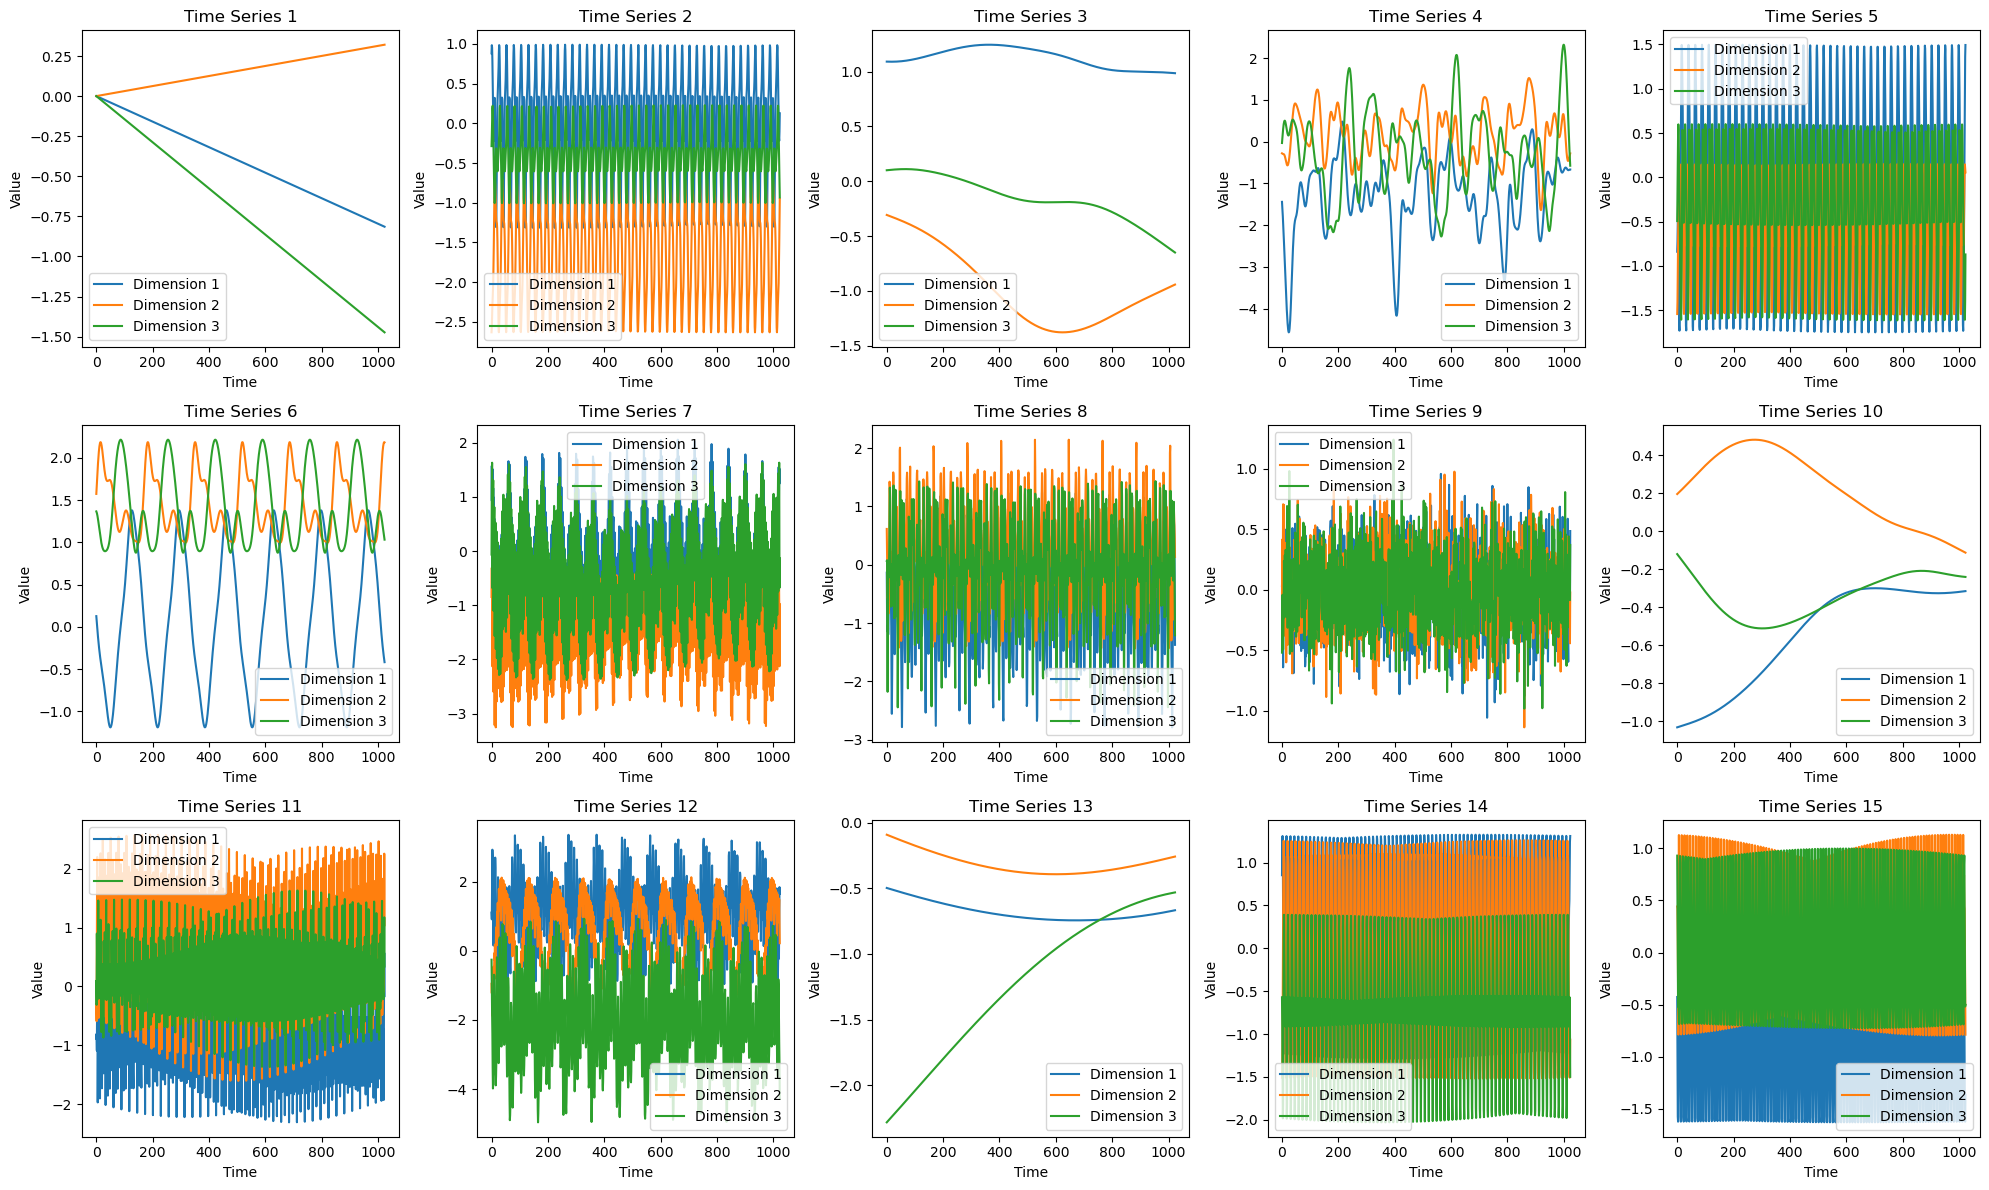

In [31]:
# Function to plot multivariate time series
def plot_multivariate_time_series(data, num_rows=3, num_cols=5):
    num_series = num_rows * num_cols
    time_points = np.arange(len(data[0]) // 3)  # 1024 time points for reshaped data
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axs = axs.flatten()  # Flatten to easily iterate over subplots
    
    for i in range(num_series):
        series = np.array(data[i]).reshape(-1, 3)  # Reshape to [1024, 3]
        for j in range(series.shape[1]):
            axs[i].plot(time_points, series[:, j], label=f'Dimension {j+1}')
        axs[i].set_title(f'Time Series {i+1}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Value')
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

# Extract the 'target' column as a list and plot the first 15 multivariate time series
plot_multivariate_time_series(df_ch_mult['target'].head(15).tolist(), num_rows=3, num_cols=5)

## DYNOTEARS Causal Structure

In [16]:
from causalnex.structure.notears import from_pandas
df_str = df.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [17]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("supporting_files_dynotears/01_fully_connected.html")

supporting_files_dynotears/01_fully_connected.html


In [18]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

supporting_files_dynotears/01_thresholded.html


In [20]:
from causalnex.structure.notears import from_pandas
df_str = df.drop(columns=['Datetime (UTC)'])
sm = from_pandas(df_str)

In [21]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("supporting_files_dynotears/01_thresholded.html")

supporting_files_dynotears/01_thresholded.html


## Granger causality test with nonlinear forecasting methods

In [22]:
!pip install nonlincausality


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  7 23:29:32 2022

@author: Maciej Rosoł

contact: mrosol5@gmail.com, maciej.rosol.dokt@pw.edu.pl
"""
#%%
import os

# os.chdir(os.path.dirname(__file__))
import numpy as np
##import tensorflow
import nonlincausality as nlc
import matplotlib.pyplot as plt
import copy
from nonlincausality.utils import prepare_data_for_prediction, calculate_pred_and_errors
from sklearn.svm import SVR

In [ ]:
#%% Data generation Y->X
np.random.seed(10)
y = (
    np.cos(np.linspace(0, 20, 10_100))
    + np.sin(np.linspace(0, 3, 10_100))
    - 0.2 * np.random.random(10_100)
)
np.random.seed(20)
x = 2 * y ** 3 - 5 * y ** 2 + 0.3 * y + 2 - 0.05 * np.random.random(10_100)
data = np.vstack([x[:-100], y[100:]]).T

plt.figure()
plt.plot(data[:, 0], label="X")
plt.plot(data[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

#%% Test in case of presence of the causality
lags = [50, 150]
data_train = data[:6000, :]
data_val = data[6000:8000, :]
data_test = data[8000:, :]



In [ ]:
results = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

#%% Example of obtaining the results
for lag in lags:
    best_model_X = results[lag].best_model_X
    best_model_XY = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)
    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"Test statistic = {test_statistic} p-value = {p_value}")

    # Using models for prediction
    data_X, data_XY = prepare_data_for_prediction(data_test, lag)
    X_pred_X = best_model_X.predict(data_X)
    X_pred_XY = best_model_XY.predict(data_XY)

    # Plot of true X vs X predicted
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data_test[lag:, 0], X_pred_X, "o")
    ax[0].set_xlabel("X test values")
    ax[0].set_ylabel("Predicted X values")
    ax[0].set_title("Model based on X")
    ax[1].plot(data_test[lag:, 0], X_pred_XY, "o")
    ax[1].set_xlabel("X test values")
    ax[1].set_ylabel("Predicted X values")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

    # Another way of obtaining predicted values (and errors)
    X_pred_X, X_pred_XY, error_X, error_XY = calculate_pred_and_errors(
        data_test[lag:, 0], 
        data_X, 
        data_XY, 
        best_model_X, 
        best_model_XY
    )
    # Plot of X predicted vs prediction error
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(X_pred_X, error_X, "o")
    ax[0].set_xlabel("Predicted X values")
    ax[0].set_ylabel("Prediction errors")
    ax[0].set_title("Model based on X")
    ax[1].plot(X_pred_XY, error_XY, "o")
    ax[1].set_xlabel("Predicted X values")
    ax[1].set_ylabel("Prediction errors")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)


In [ ]:
#%% Test in case of absence of the causality
np.random.seed(30)
data_noise = np.vstack([x[:-100], np.random.random(10_000)]).T

lags = [50, 150]
data_noise_train = data_noise[:6000, :]
data_noise_val = data_noise[6000:8000, :]
data_noise_test = data_noise[8000:, :]

results = nlc.nonlincausalityNN(
    x=data_noise_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_noise_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.001, 0.0001],
    batch_size_num=32,
    x_val=data_noise_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

#%% Example of obtaining the results
for lag in lags:
    best_model_X_lag50 = results[lag].best_model_X
    best_model_XY_lag50 = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag].test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)

    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"test statistic = {test_statistic} p-value = {p_value}")
#%% Example of the measure of the causality change over time

data_test_measure = copy.copy(data_test)
np.random.seed(30)
data_test_measure[:1000, 1] = np.random.random(1000)

plt.figure()
plt.plot(data_test_measure[:, 0], label="X")
plt.plot(data_test_measure[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

results = nlc.nonlincausalitymeasureNN(
    x=data_train,
    maxlag=lags,
    window=100,
    step=1,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test_measure,
    run=3,
    epochs_num=[50,50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    verbose=True,
    plot=True,
)


#%% Example of usage for conditional analysis
np.random.seed(30)
z = np.random.random([10_000, 2])

z_train = z[:6000, :]
z_val = z[6000:8000, :]
z_test = z[8000:, :]

results_conditional = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=1,
    z=z_train,
    z_test=z_test,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    z_val=z_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)
# %% Exaple of the usage the package with Scikit-learn model

parametres = {
    'kernel':['poly', 'rbf'],
    'C':[0.01,0.1,1], 
    'epsilon':[0.01,0.1,1.]
}
results_skl = nlc.nonlincausality_sklearn(    
    x=data_train,
    sklearn_model=SVR,
    maxlag=lags,
    params=parametres,
    x_test=data_test,
    x_val=data_val,
    plot=True)

#%% Example of usage other functions for causality analysis

# ARIMA/ARIMAX models
results_ARIMA = nlc.nonlincausalityARIMA(x=data_train[::10], maxlag=[5,15], x_test=data_test[::10])